In [2]:
%load_ext autoreload
%autoreload 2
import sys
import gc

from multiprocessing import cpu_count, Pool
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as data_utils
import matplotlib.pyplot as plt

from tqdm import tqdm

sys.path.append('../')
from wiki.utils import clock
from wiki import rnn, rnn_predict, newphet, val
%matplotlib inline

In [3]:
torch.manual_seed(1)
torch.cuda.set_device(0)

In [4]:
batch_size = 1024
pred_len = 62

In [5]:
base_dir = '../data/'
train_df = pd.read_csv(base_dir+'train_2.csv').fillna(0)

In [6]:
X = train_df.drop('Page', axis=1).values
X, scaler = rnn.scale_values(X)

In [7]:
X[:,-2*pred_len-430:-2*pred_len,:].shape

(145063, 430, 1)

In [8]:
trainloader = data_utils.DataLoader(
    data_utils.TensorDataset(
        torch.from_numpy(X[:,-2*pred_len-430:-2*pred_len,:]).float(),
        torch.from_numpy(X[:,-2*pred_len:-pred_len,:]).float()
    ),
    batch_size=batch_size, shuffle=False
)

In [9]:
valloader = data_utils.DataLoader(
    data_utils.TensorDataset(
        torch.from_numpy(X[:,:-pred_len,:]).float(),
        torch.from_numpy(X[:,-pred_len:,:]).float()
    ),
    batch_size=batch_size, shuffle=False
)

In [10]:
model = rnn.RNN().cuda()
save_best_path = base_dir+'rnn_stage2_v2_lr2.mdl'
model.load_state_dict(torch.load(save_best_path))

In [11]:
outputs, targets, sequences = model.predict(valloader)

In [12]:
_, predictions = rnn_predict.combine_prediction_data(outputs, targets, sequences)

In [13]:
prophet = pd.read_feather('../data/prophet/proph_v7_preds.f')

In [14]:
prophet.head()

,page_index,2017-07-03,2017-07-04,2017-07-05,2017-07-06,2017-07-07,2017-07-08,2017-07-09,2017-07-10,2017-07-11,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
0,176,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0
1,1388,10.0,10.0,11.0,11.0,10.0,12.0,10.0,10.0,9.0,...,10.0,11.0,12.0,11.0,13.0,11.0,11.0,10.0,11.0,12.0
2,1973,59.0,60.0,49.0,46.0,46.0,81.0,68.0,40.0,42.0,...,36.0,28.0,27.0,30.0,67.0,57.0,31.0,35.0,28.0,28.0
3,2837,40.0,24.0,20.0,22.0,22.0,23.0,38.0,43.0,27.0,...,25.0,21.0,22.0,22.0,23.0,37.0,42.0,26.0,22.0,23.0
4,4311,356.0,322.0,350.0,320.0,193.0,110.0,248.0,311.0,288.0,...,313.0,358.0,343.0,232.0,162.0,312.0,387.0,374.0,420.0,407.0


In [15]:
base_dir = '../data/'
train_df = pd.read_csv(base_dir+'train_2.csv')
X = train_df.drop('Page', axis=1).values

In [16]:
predictions = scaler.inverse_transform(predictions.T).T
true = X

In [17]:
predictions = predictions.round().clip(0)

In [18]:
median = np.nan_to_num(np.nanmedian(true[:,-49-60:-60], axis=1).reshape(-1,1).clip(0).round())

/home/ubuntu/miniconda3/envs/basev1/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [118]:
np.nanmean(val.smape(true[:,-60:], predictions[:,-60:], axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


43.341507158056743

In [119]:
np.nanmean(val.smape(true[:,-60:], median, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


41.043204039840212

In [120]:
np.nanmean(val.smape(true[:,-60:], (1.5*median+predictions[:,-60:])/2.5, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.54746183446337

In [19]:
broadcast = np.broadcast_to(median, (median.shape[0], 60))

In [122]:
median_prophet = []
for row in broadcast:
    median_prophet.append(row)

In [123]:
for _, row in prophet.iterrows():
    median_prophet[int(row[0])] = row[1:]

In [124]:
median_prophet = np.stack(median_prophet)

In [125]:
np.nanmean(val.smape(true[:,-60:], median_prophet, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.73234583840145

In [126]:
np.nanmean(val.smape(true[:,-60:], (1.5*median_prophet+predictions[:,-60:])/2.5, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.058137745273854

In [127]:
def roll(true, predictions):
    rolling_smapes = []
    for i in range(59):
        rolling_smapes.append(np.nanmean(val.smape(true[:, -60:-60+i+1], predictions[:,-60:-60+i+1], axis=1)))
    rolling_smapes.append(np.nanmean(val.smape(true[:,-60:], predictions[:,-60:], axis=1)))
    return rolling_smapes

In [128]:
with clock():
    rolling_rnn = roll(true, predictions)
    rolling_median = roll(true, median_prophet)

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


Elapsed time 16.554712295532227 seconds


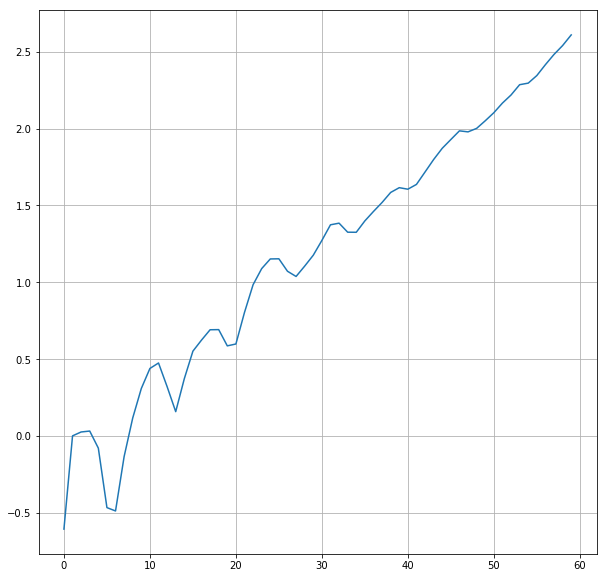

In [131]:
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(True)
ax.plot([x-y for x,y in zip(rolling_rnn, rolling_median)])

In [174]:
rolling_blend = np.stack(
    [(predictions[:, -60+x]*(2-x*0.05)+median_prophet[:,-60+x]*(1+x*0.05))/3 for x in range(20)],
    axis=1
)

In [175]:
rolling_blend = np.concatenate([rolling_blend, (2*median_prophet[:,-40:]+predictions[:,-40:])/3], axis=1)

In [183]:
median_prophet.shape

(145063, 60)

In [184]:
broadcast.shape

(145063, 60)

In [182]:
rolling_blend.shape

(145063, 60)

In [164]:
np.nanmean(val.smape(true[:,-60:], rolling_blend, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.008773240500567

Now gonna try both the good blends but just replacing with prophet at the end, rather than submitting it to blending

In [169]:
blended_1 = (1.5*median+predictions[:,-60:])/2.5

In [20]:
blended_roll = np.stack(
    [(predictions[:, -60+x]*(2-x*0.05)+broadcast[:,-60+x]*(1+x*0.05))/3 for x in range(20)],
    axis=1
)
blended_roll = np.concatenate([blended_roll, (2*broadcast[:,-40:]+predictions[:,-40:])/3], axis=1)

In [21]:
np.nanmean(val.smape(true[:,-60:], blended_roll, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.487231721276565

In [191]:
blend_1_replace = []
for row in blended_1:
    blend_1_replace.append(row)
for _, row in prophet.iterrows():
    blend_1_replace[int(row[0])] = row[1:]
blend_1_replace = np.stack(blend_1_replace)

In [192]:
blended_roll_replace = []
for row in blended_roll:
    blended_roll_replace.append(row)
for _, row in prophet.iterrows():
    blended_roll_replace[int(row[0])] = row[1:]
blended_roll_replace = np.stack(blended_roll_replace)

In [193]:
np.nanmean(val.smape(true[:,-60:], blend_1_replace, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.463441444326833

In [194]:
np.nanmean(val.smape(true[:,-60:], blended_roll_replace, axis=1))

../wiki/val.py:6: RuntimeWarning: invalid value encountered in true_divide
  diff = np.abs(y_true - y_pred) / denominator
../wiki/val.py:8: RuntimeWarning: Mean of empty slice
  return np.nanmean(diff) if axis is None else np.nanmean(diff, axis=axis)


40.402633660290768

Prepare predictions to send to Dan

In [206]:
pd.DataFrame(predictions[:,-60:], columns=['date '+str(i) for i in range(1,61)]).to_feather('../data/rnn_final_preds.f')